In [1]:
import matplotlib.pyplot as plt
# ^^^ pyforest auto-imports - don't write above this line
#Required modules
import datetime 
import calendar
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
import random
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [3]:
#Loading data
df = pd.read_csv('DS_MiniProject_ANON.csv')
print(df.shape)
df.head()

(130086, 29)


,DATE_FOR,RTD_ST_CD,CustomerSegment,Tenure,Age,MART_STATUS,GENDER,CHANNEL1_6M,CHANNEL2_6M,CHANNEL3_6M,...,CHANNEL5_3M,METHOD1_3M,PAYMENTS_3M,NOT_DI_3M,NOT_DI_6M,EVENT1_30_FLAG,EVENT2_90_SUM,LOGINS,POLICYPURCHASECHANNEL,Call_Flag
0,5/19/2014,ST_S0,1,16.175222,78.403833,MS_S0,F,0.0,0.0,1.0,...,2,0,3,0,0,0,0,0,0,0
1,5/17/2014,ST_S0,1,15.931554,70.989733,MS_S1,F,0.0,6.0,0.0,...,0,3,3,0,0,0,0,0,0,0
2,5/15/2014,ST_S0,1,15.937029,87.578371,MS_S2,M,0.0,0.0,10.0,...,0,0,6,0,0,0,0,0,0,0
3,5/16/2014,ST_S1,1,15.934292,68.438056,MS_S2,M,0.0,0.0,1.0,...,0,0,0,0,0,0,0,0,1,0
4,5/20/2014,ST_S0,1,15.501711,80.514716,MS_S0,F,0.0,0.0,1.0,...,0,0,1,0,0,0,0,0,0,0


In [4]:
#Converting Date to weekday names
df['Day_of_Week'] = pd.to_datetime(df['DATE_FOR']).dt.weekday_name

In [5]:
print("shape before drop",df.shape)
print(df.isnull().sum())
df = df.dropna()
print("shape after drop",df.shape)
print(df.isnull().sum())

shape before drop (130086, 30)
DATE_FOR                   0
RTD_ST_CD                  0
CustomerSegment            0
Tenure                     0
Age                        0
MART_STATUS                0
GENDER                     0
CHANNEL1_6M              809
CHANNEL2_6M              809
CHANNEL3_6M              809
CHANNEL4_6M              809
CHANNEL5_6M              809
METHOD1_6M               809
RECENT_PAYMENT           809
PAYMENTS_6M              809
CHANNEL1_3M                0
CHANNEL2_3M                0
CHANNEL3_3M                0
CHANNEL4_3M                0
CHANNEL5_3M                0
METHOD1_3M                 0
PAYMENTS_3M                0
NOT_DI_3M                  0
NOT_DI_6M                  0
EVENT1_30_FLAG             0
EVENT2_90_SUM              0
LOGINS                     0
POLICYPURCHASECHANNEL      0
Call_Flag                  0
Day_of_Week                0
dtype: int64
shape after drop (129277, 30)
DATE_FOR                 0
RTD_ST_CD                0
Cu

In [6]:
Colnames = list(df.columns)
print(Colnames)

['DATE_FOR', 'RTD_ST_CD', 'CustomerSegment', 'Tenure', 'Age', 'MART_STATUS', 'GENDER', 'CHANNEL1_6M', 'CHANNEL2_6M', 'CHANNEL3_6M', 'CHANNEL4_6M', 'CHANNEL5_6M', 'METHOD1_6M', 'RECENT_PAYMENT', 'PAYMENTS_6M', 'CHANNEL1_3M', 'CHANNEL2_3M', 'CHANNEL3_3M', 'CHANNEL4_3M', 'CHANNEL5_3M', 'METHOD1_3M', 'PAYMENTS_3M', 'NOT_DI_3M', 'NOT_DI_6M', 'EVENT1_30_FLAG', 'EVENT2_90_SUM', 'LOGINS', 'POLICYPURCHASECHANNEL', 'Call_Flag', 'Day_of_Week']


In [7]:
cat_cols = ['Day_of_Week','DATE_FOR','RTD_ST_CD','CustomerSegment','MART_STATUS','GENDER','RECENT_PAYMENT','NOT_DI_3M','NOT_DI_6M', 'EVENT1_30_FLAG',
 'POLICYPURCHASECHANNEL']
df_cat = df[cat_cols]
df_cat.isnull().sum()
print(df_cat.apply(lambda x: x.value_counts()).T.stack())

Day_of_Week            Friday        16476.0
                       Monday        16597.0
                       Saturday      15938.0
                       Sunday        16884.0
                       Thursday      16522.0
                       Tuesday       30073.0
                       Wednesday     16787.0
DATE_FOR               5/13/2014     15162.0
                       5/14/2014     16787.0
                       5/15/2014     16522.0
                       5/16/2014     16476.0
                       5/17/2014     15938.0
                       5/18/2014     16884.0
                       5/19/2014     16597.0
                       5/20/2014     14911.0
RTD_ST_CD              ST_S0          8477.0
                       ST_S1          1149.0
                       ST_S10         1154.0
                       ST_S11         4222.0
                       ST_S12         2252.0
                       ST_S13          933.0
                       ST_S14         7656.0
          

In [8]:
df = df.drop(['EVENT1_30_FLAG'], axis=1)
print(df.head())

    DATE_FOR RTD_ST_CD CustomerSegment     Tenure        Age MART_STATUS  \
0  5/19/2014     ST_S0               1  16.175222  78.403833       MS_S0   
1  5/17/2014     ST_S0               1  15.931554  70.989733       MS_S1   
2  5/15/2014     ST_S0               1  15.937029  87.578371       MS_S2   
3  5/16/2014     ST_S1               1  15.934292  68.438056       MS_S2   
4  5/20/2014     ST_S0               1  15.501711  80.514716       MS_S0   

  GENDER  CHANNEL1_6M  CHANNEL2_6M  CHANNEL3_6M     ...       CHANNEL5_3M  \
0      F          0.0          0.0          1.0     ...                 2   
1      F          0.0          6.0          0.0     ...                 0   
2      M          0.0          0.0         10.0     ...                 0   
3      M          0.0          0.0          1.0     ...                 0   
4      F          0.0          0.0          1.0     ...                 0   

   METHOD1_3M  PAYMENTS_3M  NOT_DI_3M  NOT_DI_6M  EVENT2_90_SUM  LOGINS  \
0    

In [9]:
cat_cols.remove('EVENT1_30_FLAG')
df_final = pd.get_dummies(df, columns=cat_cols)
df_final.columns
print(df_final.shape)

(129277, 104)


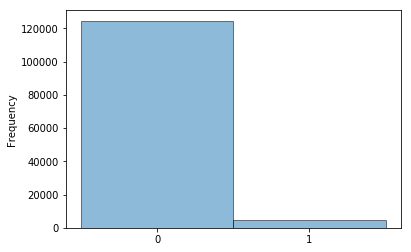

In [10]:
df_final.Call_Flag.plot(kind='hist',bins=[-.5,.5,1.5], ec="k", alpha=0.5)
plt.xticks((0,1))
plt.show()

In [11]:
random.seed(42)
train, test = train_test_split(df_final, test_size=0.20, stratify=df_final['Call_Flag']) 

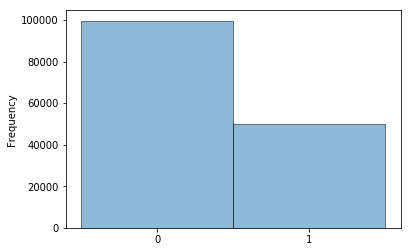

In [12]:
#Oversampling to handle imbalanced data
from sklearn.utils import resample
train_majority = train[train["Call_Flag"] == 0]
train_minority = train[train["Call_Flag"] == 1]
train_minority_upsampled = resample(train_minority, 
                                 replace=True,     
                                 n_samples=50000,    
                                 random_state=42) 
df_train = pd.concat([train_majority, train_minority_upsampled])

 
# Display new class counts
# Display new class counts
df_train.Call_Flag.plot(kind='hist',bins=[-.5,.5,1.5], ec="k", alpha=0.5)
plt.xticks((0,1))
plt.show()


In [13]:
X = df_train.drop(['Call_Flag'], axis=1)
y = df_train['Call_Flag'].values

Let's set up a parameter grid that will be explored during the search. Note that you can use fewer parameters and fewer options for each parameter. Same goes for more parameter and more options if you want to be very thorough. Also, you can plug in any other ML method instead of XGBoost and search for its optimal parameters.

In [14]:
# A parameter grid for XGBoost
params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5, 6, 8, 9, 10, 15],
        'learning_rate':[0.001,0.01,0.1,0.2,0.5,0.9],
        'n_estimators':[50,100,200,300,400,500,600,700,800,900,1000]
        }


A total number of combinations for the set of parameters above is a product of options for each parameter (3 x 5 x 3 x 3 x 3 = 405). It also needs to be multiplied by 5 to calculate a total number of data-fitting runs as we will be doing 5-fold cross-validation. That gets to be a large number in a hurry if you are using many parameters and lots of options, which is why **brute-force grid search takes a long time**.

Next we set up our classifier. We use sklearn's API of XGBoost as that is a requirement for grid search (another reason why Bayesian optimization may be preferable, as it does not need to be sklearn-wrapped). You should consider setting a learning rate to smaller value (at least 0.01, if not even lower), or make it a hyperparameter for grid searching. I am not using very small value here to save on running time. 

*Even though we have 4 threads available per job on Kaggle, I think it is more efficient to do XGBoost runs on single threads, but instead run 4 parallel jobs in the grid search. It's up to you whether you want to change this.*

In [15]:
xgb = XGBClassifier(objective='binary:logistic',silent=True, nthread=12)

Next we set up our stratified folds and grid search parameters. I am using AUC as a scoring function, but you can plug in a custom scoring function here if you wish. Grid search wil spawn 4 jobs running a single thread each. The param_comb parameter declares how many different combinations should be picked randomly out of our total (405, see above). I am doing only 5 here, knowing that it will not properly sample the parameter space. Definitely use a bigger number for param_comb.

*You may want to increase/decrease verbosity depending on your preference.*

**Note that I have set the number of splits/folds to 3 in order to save time. You should probably put 5 there to get a more reliable result.**

In [ ]:
folds = 5
param_comb = 20

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=12, cv=skf.split(X, y), verbose=3, random_state=42 )

# Here we go
start_time = timer(None) # timing starts from this point for "start_time" variable
random_search.fit(X, y)
timer(start_time) # timing ends here for "start_time" variable


Fitting 5 folds for each of 20 candidates, totalling 100 fits


You can actually follow along as the search goes on. To convert to normalized gini, multiply the obtained AUC values by 2 and subtract 1.

Let's print the grid-search results and save them in a file.

In [ ]:
print('\n All results:')
print(random_search.cv_results_)
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)
results = pd.DataFrame(random_search.cv_results_)
results.to_csv('xgb-random-grid-search-results-01.csv', index=False)


Not surprisingly, this search does not produce a great score because of 3-fold validation and limited parameter sampling.

Lastly, let's make a prediction based on best parameters found during the search.

In [ ]:
X_test = test.drop(['Call_Flag'], axis=1)
y_test = test['Call_Flag'].values

In [ ]:
y_predict = random_search.predict(X_test)
y_predict_probs = random_search.predict_proba(X_test)

In [ ]:
from sklearn.metrics import classification_report
target_names = ['0', '1']
print(classification_report(y_test, y_predict, target_names=target_names))

In [ ]:
from sklearn.metrics import roc_auc_score

# Calculate roc auc
roc_value = roc_auc_score(y_test, y_predict_probs[:, 1])
roc_value

In [ ]:
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
RF_roc_auc = roc_auc_score(y_test, y_predict)
fpr, tpr, thresholds = roc_curve(y_test, y_predict)
plt.figure()
plt.plot(fpr, tpr, label='XGB_3 (area = %0.2f)' % roc_value)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('xgboost with Resampling_ROC')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_predict)

In [ ]:
Ys = np.column_stack((y_predict, y_test))
from numpy import savetxt
savetxt('Ys_xgb_resampled_40000.csv', Ys, delimiter=',')

In [ ]:
y_prob = random_search.predict_proba(X_test)
Ys_prob = np.column_stack((y_prob, y_test))
from numpy import savetxt
savetxt('Ys_xgb_resampled_more_combs_prob.csv', Ys_prob, delimiter=',')